# Web Analytics/Web Usage Mining

In [1]:
# Import necessary libraries

import pandas as pd
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import gower
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import squareform

In [2]:
# Import datasets with pandas

sem = pd.read_csv('./wum_dataset_hw/search_engine_map.csv')
visitors = pd.read_csv('./wum_dataset_hw/visitors.csv')
clicks = pd.read_csv('./wum_dataset_hw/clicks.csv')


## General statistics

In [13]:
print("Number of visits: {} ".format(visitors["VisitID"].count()))
print("Number of users: {} ".format(sem["Referrer"].count()))
print("Number of clicks: {} ".format(clicks["LocalID"].count()))
print("Average time spent on page: {:.4g} (I suppose seconds)".format(clicks["TimeOnPage"].mean()))


Number of visits: 15559 
Number of users: 140 
Number of clicks: 38451 
Average time spent on page: 72.41 (I suppose seconds)


## Pre-Processing

#### First of all I joined the three csv files, then I removed too short visits. Then I modified all the columns that have continuous values and I transformed them into categorical ones. To end up, I removed useless columns.

In [3]:
# Perform joins
df=pd.merge(clicks, visitors, how='left', on='VisitID')
df=pd.merge(df, sem, how='left', on='Referrer')

# remove too short visits
df = df[df.Length_seconds > 2]


# Modify these clumns from single values to bins
df["PageScore"] = pd.cut(df["PageScore"],5)
df["TimeOnPage"] = pd.cut(df["TimeOnPage"],5)
#df["Length_seconds"] = pd.cut(df["Length_seconds"],10)
df["Hour"] = pd.cut(df["Hour"],5)

# Drop nan values
df = df.dropna()

# Delete useless columns
del df["Length_seconds"]
del df["PageID"]
del df["LocalID"]
del df["CatID"]
del df["ExtCatID"]
del df["TopicID"]
del df["ExtCatName"]


df.head()


,VisitID,PageName,CatName,TopicName,TimeOnPage,PageScore,SequenceNumber,Referrer,Day,Hour,Length_pagecount,Type
6,1186,Norway journey to the far north Lofoten,Trip,Tourism,"(27.39, 552.0]","(24.277, 1174.6]",1,URI_38,Sunday,"(18.4, 23.0]",2.0,Fulltext
7,1186,National parks and thermal Hungary and Slovakia,Trip,Tourism,"(27.39, 552.0]","(24.277, 1174.6]",2,URI_38,Sunday,"(18.4, 23.0]",2.0,Fulltext
28,1190,hiking,Search,Hiking,"(27.39, 552.0]","(24.277, 1174.6]",2,URI_45,Monday,"(-0.023, 4.6]",2.0,Fulltext
29,1190,n news Trips,Info,In general,"(27.39, 552.0]","(24.277, 1174.6]",1,URI_45,Monday,"(-0.023, 4.6]",2.0,Fulltext
31,1192,TravelAgency,Info,In general,"(27.39, 552.0]","(24.277, 1174.6]",1,URI_9,Monday,"(-0.023, 4.6]",8.0,Catalogue


#### As final pre-processing step I transformed the dataset from a pandas dataframe to a list of object before (but it didn't work) and then into a list of lists (and it worked).

In [42]:

dataset = []
for index, row in df.iterrows():
    
    # List of objects didn't work
    #obj = {}
    #for col in list(df):
        #obj[col] = str(row[col])
    #dataset.append(obj)
    
    # List of list works
    row = [col + "=" + str(row[col]) for col in list(df)]
    dataset.append(row)
    
print(*dataset[:10], sep="\n")


['VisitID=1186', 'PageName=Norway journey to the far north Lofoten', 'CatName=Trip', 'TopicName=Tourism', 'TimeOnPage=(27.39, 552.0]', 'PageScore=(24.277, 1174.6]', 'SequenceNumber=1', 'Referrer=URI_38', 'Day=Sunday', 'Hour=(18.4, 23.0]', 'Length_pagecount=2.0', 'Type=Fulltext']
['VisitID=1186', 'PageName=National parks and thermal Hungary and Slovakia', 'CatName=Trip', 'TopicName=Tourism', 'TimeOnPage=(27.39, 552.0]', 'PageScore=(24.277, 1174.6]', 'SequenceNumber=2', 'Referrer=URI_38', 'Day=Sunday', 'Hour=(18.4, 23.0]', 'Length_pagecount=2.0', 'Type=Fulltext']
['VisitID=1190', 'PageName=hiking', 'CatName=Search', 'TopicName=Hiking', 'TimeOnPage=(27.39, 552.0]', 'PageScore=(24.277, 1174.6]', 'SequenceNumber=2', 'Referrer=URI_45', 'Day=Monday', 'Hour=(-0.023, 4.6]', 'Length_pagecount=2.0', 'Type=Fulltext']
['VisitID=1190', 'PageName=n news Trips', 'CatName=Info', 'TopicName=In general', 'TimeOnPage=(27.39, 552.0]', 'PageScore=(24.277, 1174.6]', 'SequenceNumber=1', 'Referrer=URI_45', 'Da

## Association rule task

In [43]:

def frequentItems(transactions, support):
    counter = Counter()
    for trans in transactions:
        counter.update(frozenset([t]) for t in trans)
    return set(item for item in counter if counter[item] / len(transactions) >= support), counter


def generateCandidates(L, k):
    candidates = set()
    for a in L:
        for b in L:
            union = a | b
            if len(union) == k and a != b:
                candidates.add(union)
    return candidates


def filterCandidates(transactions, itemsets, support):
    counter = Counter()
    for trans in transactions:
        subsets = [itemset for itemset in itemsets if itemset.issubset(trans)]
        counter.update(subsets)
    return set(item for item in counter if counter[item] / len(transactions) >= support), counter


def apriori(transactions, support):
    result = list()
    resultc = Counter()
    candidates, counter = frequentItems(transactions, support)
    result += candidates
    resultc += counter
    k = 2
    while candidates:
        candidates = generateCandidates(candidates, k)
        candidates, counter = filterCandidates(transactions, candidates, support)
        result += candidates
        resultc += counter
        k += 1
    resultc = {item: (resultc[item] / len(transactions)) for item in resultc}
    return result, resultc

def generate_tuples(itemset: frozenset):
    itemlist = list(itemset)
    res = []
    for item in itemlist:
        newlist = list(itemlist)
        newlist.remove(item)
        res.append((newlist, item))
    return res


def genereate_rules(frequent_itemsets, supports, min_conf):
    results = []
    for itemset in frequent_itemsets:
           
        if len(itemset) < 2:
            continue

        for couple in generate_tuples(itemset):
            conf = supports[itemset] / supports[frozenset(couple[0])]
            if conf >= min_conf:
                results.append((couple[0], couple[1], conf, supports[itemset]))
                
    results = sorted(results, key=lambda x: (x[2], x[3]), reverse=True)
        
    return results

In [44]:
frequent_itemsets, supports = apriori(dataset, 0.05)

for f in frequent_itemsets:
    print("{} - {}".format(set(f), supports[f]))


{'Type=Catalogue'} - 0.1633720930232558
{'Referrer=URI_39'} - 0.08706395348837209
{'Hour=(9.2, 13.8]'} - 0.33292151162790695
{'TopicName=Hiking'} - 0.06751453488372093
{'Referrer=URI_45'} - 0.06824127906976744
{'Type=Partners'} - 0.10334302325581396
{'TimeOnPage=(27.39, 552.0]'} - 0.9832848837209303
{'Day=Sunday'} - 0.10472383720930233
{'TopicName=exotica'} - 0.05036337209302326
{'Length_pagecount=4.0'} - 0.14098837209302326
{'Length_pagecount=5.0'} - 0.10392441860465117
{'SequenceNumber=1'} - 0.21700581395348836
{'Type=OwnWebs'} - 0.07441860465116279
{'CatName=Trip'} - 0.35574127906976744
{'Day=Thursday'} - 0.13386627906976745
{'SequenceNumber=3'} - 0.16242732558139536
{'Day=Wednesday'} - 0.15915697674418605
{'Day=Saturday'} - 0.08125
{'PageScore=(24.277, 1174.6]'} - 0.9830668604651163
{'TopicName=Tourism'} - 0.07609011627906977
{'Referrer=URI_9'} - 0.14280523255813954
{'SequenceNumber=5'} - 0.06991279069767442
{'CatName=Search'} - 0.45545058139534883
{'TopicName=Tours with accommodat

In [49]:
results = genereate_rules(frequent_itemsets, supports, 0.4)

c = 0
for res in results:
    if(res[2] < 0.9 and c < 100): # comment to see full results
        c += 1
        print("{}) {} => {} has confidence: {} and support {} ".format( c, res[0], res[1], res[2], res[3]))
    

1) ['TimeOnPage=(27.39, 552.0]', 'SequenceNumber=1'] => PageScore=(24.277, 1174.6] has confidence: 1.0 and support 0.21286337209302325 
2) ['TimeOnPage=(27.39, 552.0]', 'SequenceNumber=2'] => PageScore=(24.277, 1174.6] has confidence: 1.0 and support 0.2125 
3) ['Referrer=URI_42'] => Type=Fulltext has confidence: 1.0 and support 0.19796511627906976 
4) ['Referrer=URI_42', 'TimeOnPage=(27.39, 552.0]'] => Type=Fulltext has confidence: 1.0 and support 0.19498546511627907 
5) ['Referrer=URI_42', 'PageScore=(24.277, 1174.6]'] => Type=Fulltext has confidence: 1.0 and support 0.19440406976744187 
6) ['Referrer=URI_42', 'TimeOnPage=(27.39, 552.0]', 'PageScore=(24.277, 1174.6]'] => Type=Fulltext has confidence: 1.0 and support 0.19367732558139536 
7) ['CatName=Info'] => TopicName=In general has confidence: 1.0 and support 0.18611918604651162 
8) ['PageScore=(24.277, 1174.6]', 'CatName=Info'] => TopicName=In general has confidence: 1.0 and support 0.1846656976744186 
9) ['TimeOnPage=(27.39, 552.

#### The complete results of the last two task are visible in the three files (frequent_itemsets.txt, filtered_rules.txt and full_rules.txt). At first I generated the rules without any type of costraint and it ended creating a lot of rules with confidence=1 (and they contained basically useless information). Anyway I generated the first 100 of them and saved. The rules with the highest supports are of course the 'obvious' ones: for example the number 1) and 2) mean that if people spend a lot of time on the first or second page, that page must be important (high score). Many following rules tell basically that if the page name is 'TravelAgency', that is the homepage, people spend a lot of time on it, tha category's name is 'info', the topic is 'in general', so obvoius things.
#### Given the fact that I couldn't see any interesting information I decided to filter them by selecting only the rules with a confidence < 0.9. The results are stored in the file called filtered_rule.txt . The first three say that the category 'search', a long time spent on page and the type 'catalog' are strongly related to the referrer 'URI_9'. A couple interesting rules are the number 27) that say that if I'm looking for information (CatName = 'info') I'm almost certainly looking for them in the homepage (PageName = 'TravelAgency') and the number 100) which tells that if I'm in the second page (SequenceNumber = '2') I'm looking for something specific (CatName = 'Search') and it makes sense (if I want to look for something specific I go on the homepage and then I click on the search tab). Other rules that got my attention are the number 29),31),32): they tell that the travel agency page is mainly visited in the morning (looking at the 'hour' information).


## Other task: visits clustering

#### First of all I re-arranged the dataset:

In [4]:
d=pd.merge(clicks, visitors, how='left', on='VisitID')

# Delete useless columns
del d["Length_seconds"]
del d["PageID"]
del d["TopicID"]
del d["ExtCatName"]
del d["LocalID"]
del d["CatID"]
del d["ExtCatID"]
del d["SequenceNumber"] # could be used
del d["Referrer"]

# Drop nan values
d = d.dropna()

# Keep aside visits ids 
ids = d["VisitID"]
del d["VisitID"]

d.head()

,PageName,CatName,TopicName,TimeOnPage,PageScore,Day,Hour,Length_pagecount
0,TravelAgency,Info,In general,30,30,Sunday,23.0,6.0
1,tours with tents,Search,Tourism,30,50,Sunday,23.0,6.0
2,hiking,Search,Hiking,30,62,Sunday,23.0,6.0
3,mountain expedition,Search,VHT,30,71,Sunday,23.0,6.0
4,water,Search,Water,30,78,Sunday,23.0,6.0


#### The dataset is composed of both categorical and continous values, so k-means clustering doesn't work because it uses euclidean distance to separate the points into the different clusters. For this reason I used gower distance that computes dissimilarity of tw objects composed of both categorical and numerical values and then Agglomerative clustering.

In [7]:
distance_matrix = gower.gower_matrix(d) # d.sample(n=100)

#### There are various methods to find the most appropriate number of clusters: I chose the elbow method.

/Users/davideariotto/anaconda3/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/davideariotto/anaconda3/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/davideariotto/anaconda3/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/davideariotto/anaconda3/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-n

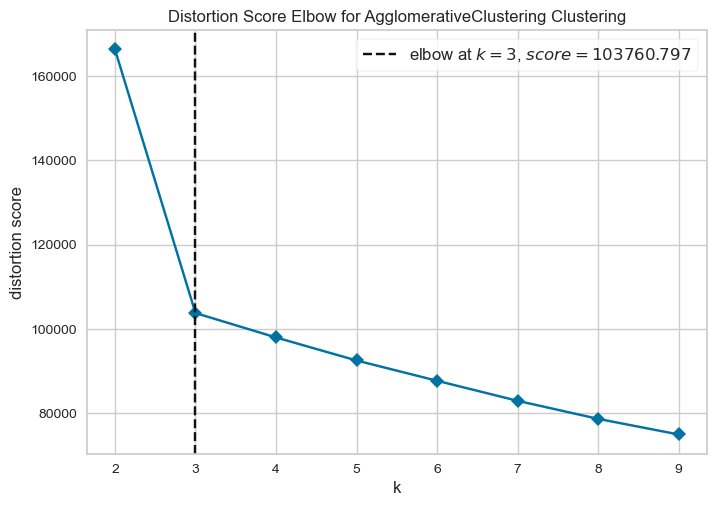

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Compute number of clusters with elbow method

model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,10), timings=False) # k = range of possible number of clusters (subjective)
#condensed_dist_matrix = squareform(distance_matrix) # condense distance matrix to avoid warning
visualizer.fit(distance_matrix)
visualizer.show()

#### Now that I found the correct number of clusters ( = 3 ), let's perform the task:

/Users/davideariotto/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


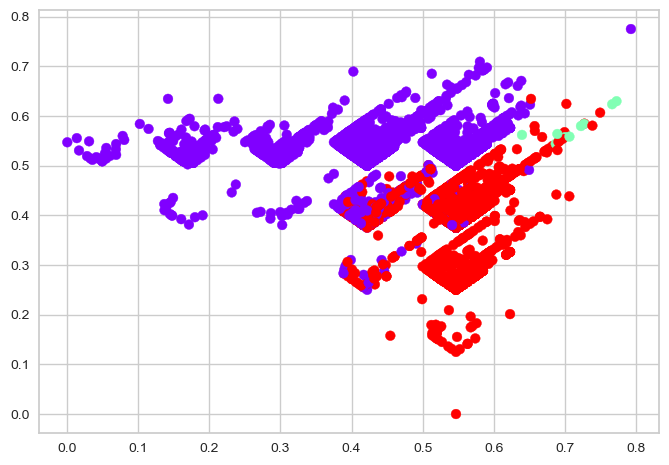

In [10]:
model = AgglomerativeClustering(n_clusters=3, linkage='average', affinity='precomputed')
model.fit_predict(distance_matrix)
plt.scatter(x=distance_matrix[:,0], y=distance_matrix[:,1], c=model.labels_, cmap='rainbow' )

## Issues and possible extensions

#### I didn't have particular issues during this homework, but I expected more interesting results. The results of the second part could be useful for implementing targeted marketing campaigns to different type of users/sites. For example, if I know that a webpage is mostly related to long sessions (users spend a lot of time in it) we could propose video ads, while if a page is related mostly to short visits we could put quick ads pop-ups. The clustering task could be even more specific like grouping users per topic of the search (travel, shopping, cooking, etc...)